<a href="https://colab.research.google.com/github/codeninja404/snapchat_clone/blob/main/soham_sequential_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries 

In [ ]:
import tensorflow as tf                                                         # using tensorflow version 2.4.1
import pandas
from keras import backend as K
from matplotlib import pyplot
import numpy as np

In [ ]:
tf.__version__

'2.4.1'

Cifar 10 Dataset <br>
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with
6000 images per class. There are 50000 training images and 10000 test images. <br>
airplane : 0 <br>
automobile : 1 <br>
bird : 2 <br>
cat : 3 <br>
deer : 4 <br>
dog : 5 <br>
frog : 6 <br>
horse : 7 <br>
ship : 8 <br>
truck : 9 <br>

In [ ]:
from tensorflow.keras.datasets import cifar10                                   #importing dataset from keras
(x_train, y_train), (x_test, y_test) = cifar10.load_data()                      #loading the dataset

170500096/170498071 [==============================] - 3s 0us/step


Preprocessing the data 

In [ ]:
def train_preprocess(image, label):
    image  = tf.image.random_flip_left_right(image)                             #Flip an image horizontally (left to right). Outputs the contents of image flipped along the width dimension.
    image = tf.image.random_brightness(image, 0.2)                              #Adjust the brightness of images by a random factor. Takes args as image, max_delta and seed. Returns the brightness adjusted images
    image  = tf.image.random_saturation(image, lower=0.5, upper=1.5)            #Adjust the saturation of RGB images by a random factor.Takes args image, lower, upper, seed. Returns Adjusted images, same shape and DType as image.
    return image, label

In [ ]:
def parse_data(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)                     #Convert image to dtype, scaling its values if needed. Takes args image, dtype, saturate, name. Returns image, converted to dtype.
    return image, label

In [ ]:
batch_size = 64                                                                 #Batch size refers to the number of training examples utilized in one iteration. In our case 64
y_t = tf.keras.utils.to_categorical(y_train, 10)                                #Converts a class vector (integers) to binary class matrix. Takes args y, num_classes, dtype. Returns a binary matrix representation of the input. The classes axis is placed last.
data = tf.data.Dataset.from_tensor_slices((x_train, y_t))                       #Creates a Dataset whose elements are slices of the given tensors. Takes args tensors. Returns dataset.
data = data.shuffle(50000)                                                      #Shuffling data serves the purpose of reducing variance and making sure that models remain general and overfit less.
data = data.map(parse_data,num_parallel_calls= 4)                               #When you use Dataset.map(map_func), TensorFlow defines a subgraph for all the ops created in the function map_func, and arranges to execute it efficiently in the same session as the rest of your graph.
data = data.map(train_preprocess, num_parallel_calls=4)
data = data.padded_batch(batch_size)                                            # Pad to the smallest per-batch size that fits all elements. Takes args batch_size, padded_shapes, padding_values, drop_remainder. Returns Dataset.
#data = data.repeat()

In [ ]:
data

<PaddedBatchDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.float32, tf.float32)>

Sequential Model <br>
Conv2D: The input to a Conv2D layer must be four-dimensional. The first dimension defines the samples. The second dimension defines the number of rows. The third dimension defines the number of columns. Fourth decides the number of channels.<br>
Maxpooling2D: Maximum pooling, or max pooling, is a pooling operation that calculates the maximum, or largest, value in each patch of each feature map.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)),         # Input shape: 4+D tensor with shape: batch_shape + (channels, rows, cols) if data_format='channels_first' or 4+D tensor with shape: batch_shape + (rows, cols, channels) if data_format='channels_last'. Output shape: 4+D tensor with shape: batch_shape + (filters, new_rows, new_cols) if data_format='channels_first' or 4+D tensor with shape: batch_shape + (new_rows, new_cols, filters) if data_format='channels_last'. rows and cols values might have changed due to padding.
    tf.keras.layers.MaxPooling2D(2, 2),                                                                                                       # Input shape: If data_format='channels_last': 4D tensor with shape (batch_size, rows, cols, channels). Output shape: If data_format='channels_last': 4D tensor with shape (batch_size, pooled_rows, pooled_cols, channels).
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(10, activation='softmax'),
               
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

Adam Optimizer:<br>
1.Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models.<br>
2.Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems.<br>
<br>
Cross Entropy Loss: <br>
1.Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1.<br>
2.Cross-entropy loss increases as the predicted probability diverges from the actual label

In [ ]:
model.compile(optimizer = "adam", 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
history = model.fit(data, epochs = 100, steps_per_epoch=20)                     #Trains the model for a fixed number of epochs (iterations on a dataset). Returns a History object. Its History.history attribute is a record of training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values (if applicable).

Epoch 1/100
20/20 [==============================] - 7s 323ms/step - loss: 0.4046 - accuracy: 0.1274
Epoch 2/100
20/20 [==============================] - 6s 322ms/step - loss: 0.3157 - accuracy: 0.2018
Epoch 3/100
20/20 [==============================] - 6s 324ms/step - loss: 0.2950 - accuracy: 0.3061
Epoch 4/100
20/20 [==============================] - 6s 321ms/step - loss: 0.2743 - accuracy: 0.3497
Epoch 5/100
20/20 [==============================] - 6s 322ms/step - loss: 0.2750 - accuracy: 0.3402
Epoch 6/100
20/20 [==============================] - 6s 323ms/step - loss: 0.2673 - accuracy: 0.3374
Epoch 7/100
20/20 [==============================] - 6s 322ms/step - loss: 0.2594 - accuracy: 0.3947
Epoch 8/100
20/20 [==============================] - 6s 321ms/step - loss: 0.2477 - accuracy: 0.4323
Epoch 9/100
20/20 [==============================] - 6s 322ms/step - loss: 0.2512 - accuracy: 0.4300
Epoch 10/100
20/20 [==============================] - 6s 320ms/step - loss: 0.2375 - accura

Visualizing the Model

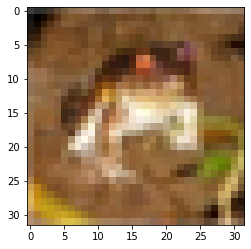

In [19]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])

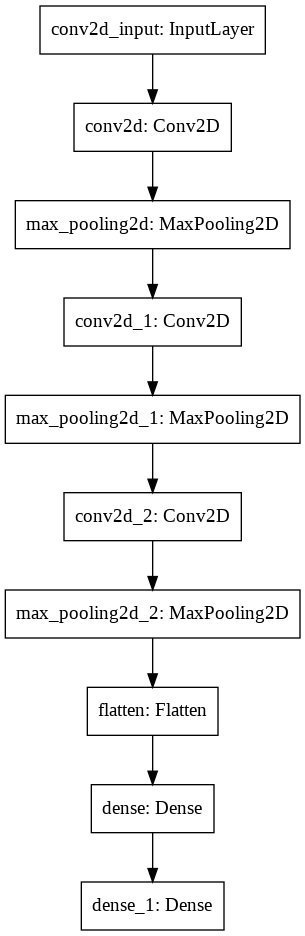

In [22]:
from keras.utils import plot_model
plot_model(model)

Visualizing the accuracy of the model

<function matplotlib.pyplot.show>

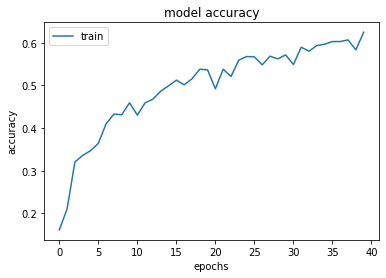

In [23]:
plt.plot(history.history['accuracy'])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(['train'], loc = 'upper left')
plt.show

Visualizing the loss of the model

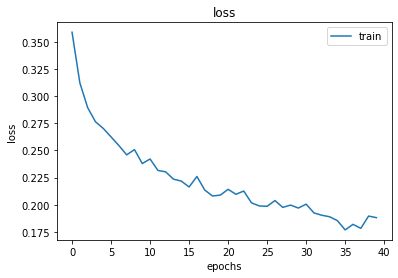

In [24]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel("epochs")
plt.legend(['train'], loc = "upper right")